# 1. Introduction: Visualizations

In [29]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#import the divvy trip data (April 2021)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/202104-divvy-tripdata.csv')

In [32]:
#only include station to station trips
df = df[df['start_station_name'].notna() & df['end_station_name'].notna()]
df = df.reset_index()

In [ ]:
df.shape

(298207, 14)

In [33]:
#create "hour" and "date" variables from trip start time stamp
df['hour'] = df['started_at'].map(lambda x: x[10:13])
df['date'] = df['started_at'].map(lambda x: x[8:10])

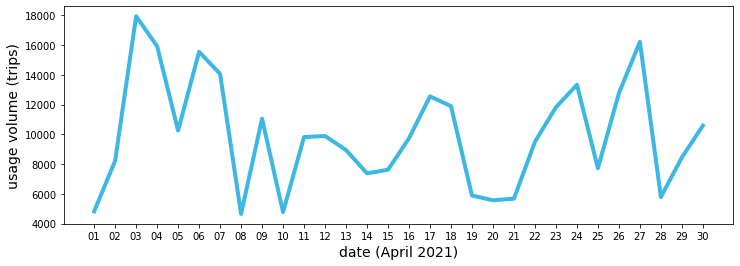

In [52]:
#visualize the distribution of bike trips by date in April 2021
fig = plt.figure(figsize = (12, 4))
comp = df['date'].value_counts().sort_index()
plt.plot(comp, color ='#3DB7E4', linewidth=4)
plt.xlabel('date (April 2021)', fontsize=14)
plt.ylabel('usage volume (trips)', fontsize=14)
#plt.show()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/f3.png', dpi=150, bbox_inches='tight')

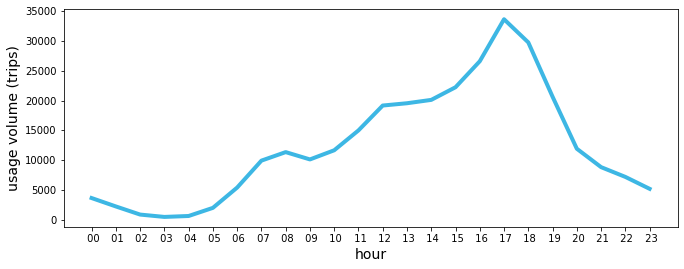

In [43]:
#visualize the distribution of bike trips by hour per day in April 2021
fig = plt.figure(figsize = (11, 4))
comp = df['hour'].value_counts().sort_index()
plt.plot(comp, color ='#3DB7E4', linewidth=4)
plt.xlabel('hour', fontsize=14)
plt.ylabel('usage volume (trips)', fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/f4.png', dpi=150, bbox_inches='tight')

In [39]:
# calculate the usage volume of each unique station
all_stations = list(df['start_station_name']) + list(df['end_station_name'])
df_stations = pd.DataFrame(pd.Series(all_stations).value_counts(), columns=['count'])

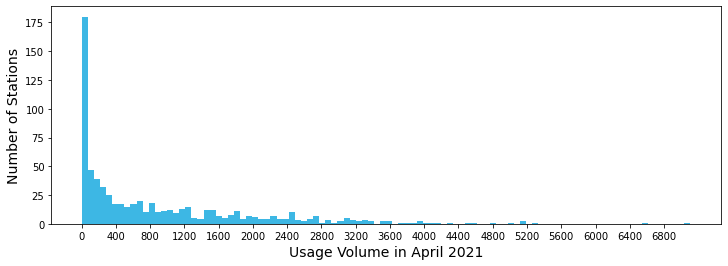

In [53]:
#visualize the distribution of stations by usage volume
plt.figure(figsize=(12,4)) #19, 7
plt.hist(df_stations['count'], bins=100, color='#3DB7E4')
plt.xticks(np.arange(0, 7200, 400))
plt.xlabel('Usage Volume in April 2021', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/f2.png', dpi=150, bbox_inches='tight')

In [34]:
# list and visualize the top 10 bike stations with the highest usage volume
top10 = df_stations['count'].head(10).sort_values()

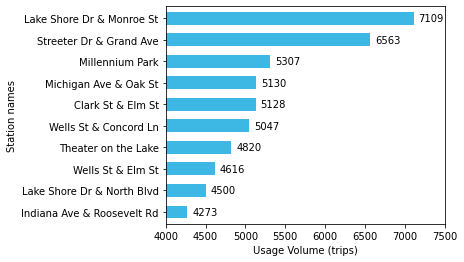

In [38]:
f,ax=plt.subplots(figsize=(5,4))
top10.plot.barh(width=0.6, color='#3DB7E4')
ax.set_xlabel('Usage Volume (trips)')
ax.set_ylabel('Station names')
ax.set_xlim(4000,7500)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 5
    ha = 'left'

    if x_value < 0:
        space *= -1
        ha = 'right'

    label = int(x_value)

    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
  
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/f5.png', dpi=150, bbox_inches='tight')

In [ ]:
#681 stations in total
df_stations.shape

(681, 1)

## Drawing the network graph

In [54]:
# combine the latitude and longitude of each bike station
df['start_loc'] = df['start_lat'].map(lambda x: str(x)[:9]) + ',' + df['start_lng'].map(lambda x: str(x)[:10])
df['end_loc'] = df['end_lat'].map(lambda x: str(x)[:9]) + ',' + df['end_lng'].map(lambda x: str(x)[:10])

In [55]:
#create a dictionary from station name to coordinates
station2coord = {}
for i in df.index:
  start_loc = df.loc[i, 'start_loc']
  start_station_name = df.loc[i, 'start_station_name']
  end_loc = df.loc[i, 'end_loc']
  end_station_name = df.loc[i, 'end_station_name']
  if start_station_name not in station2coord:
      station2coord[start_station_name] = start_loc
  if end_station_name not in station2coord:
      station2coord[end_station_name] = end_loc   

In [56]:
#record the number of trips from each start station to each end station.
trips = []
for i in df.index:
  trips.append(tuple([df.loc[i, 'start_station_name'], df.loc[i, 'end_station_name']]))
trips = pd.Series(trips)
trip_counts = trips.value_counts()

In [57]:
# record the number of trips between each start station and end station as edge weight
edge_weights = []
for i in range(len(trip_counts)):
  edge_weights.append(tuple([trip_counts.index[i][0], trip_counts.index[i][1], trip_counts[i]]))

In [58]:
#create a directed graph DG using the edge weights. Converting it to an undirected graph G.
DG = nx.DiGraph()
DG.add_weighted_edges_from(edge_weights)
G = nx.Graph(DG)

In [59]:
# record the position coordinates of each node (station) using the station2coord dictionary

pos = {}
for i in range(len(G.nodes)):
  coord = station2coord[list(G.nodes)[i]].split(',')
  pos[list(G.nodes)[i]] = (float(coord[1]), float(coord[0]))
nx.set_node_attributes(G, pos, 'coord')

In [60]:
# adjust the width of edges in the graph
weights = [G[u][v]['weight']/30 for u,v in G.edges]

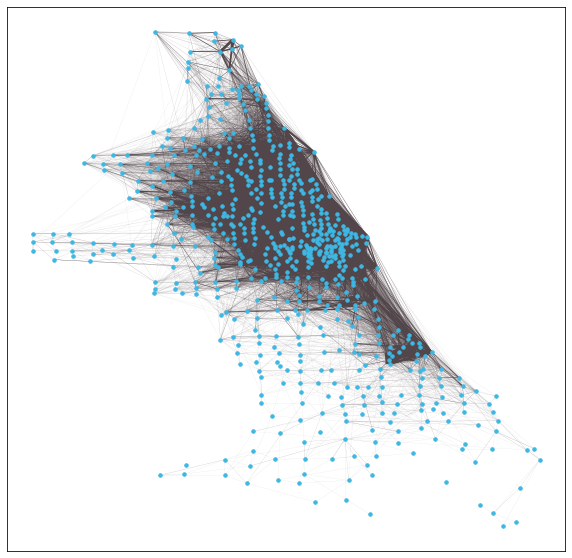

In [61]:
#plot the network graph
plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=12,node_color='#3DB7E4', node_shape="o", alpha=1)
nx.draw_networkx_edges(G, pos, width = weights, edge_color='#52464A')
#nx.draw_networkx_labels(G, pos, font_size=4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/f1.png', dpi=150, bbox_inches='tight')